# Feature Selection in Geotechnics with Featurewiz

This notebook is a hands-on tutorial that demonstrates how to perform feature selection in geotechnical datasets using the `featurewiz` library. We'll:

- Introduce the intuition behind feature selection and why it matters for geotechnical ML projects
- Create a small dummy CPT-like dataset and run `featurewiz`
- Optionally use provided raw datasets (earthquake and CPT CPT_PremstallerGeotechnik_revised.csv) to show a realistic example
- Visualize selected features and compare simple model performance before/after selection

You can run cells top-to-bottom during class.

## Theory — Why Feature Selection?

Feature selection aims to pick a subset of relevant variables that are informative for predicting a target. Benefits include:
- Simpler models that generalize better
- Reduced overfitting and improved interpretability
- Faster training and inference

`featurewiz` automates feature selection using:
- SULOV (Searching for Uncorrelated List Of Variables) to remove highly correlated and low-importance features
- Recursive feature elimination style steps based on model importances (using lightGBM/XGBoost/catboost or RF)
- Optional feature engineering (not used here for clarity)

In [1]:
# Imports and setup
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px

# featurewiz imports
from featurewiz import featurewiz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"
SEED = 42
np.random.seed(SEED)

print("featurewiz version OK; data dir exists:", RAW_DIR.exists())

Imported lazytransform v1.18. 

Imported featurewiz 0.5.82. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    
featurewiz version OK; data dir exists: False


## Part 1 — Dummy CPT-like dataset

We synthesize a small dataset that mimics common CPT features: depth, cone resistance `qc`, sleeve friction `fs`, friction ratio `Rf`, and a few engineered stress proxies. We'll define a categorical soil type target with 3 classes (e.g., coarse, intermediate, fine) based on thresholds plus noise.

In [ ]:
# Create dummy CPT-like dataset
n = 800
depth = np.linspace(0.5, 30, n)
qc = 1.5 + 0.15 * depth + np.random.lognormal(mean=0.1, sigma=0.4, size=n)
fs = 0.03 * qc + np.random.normal(0, 0.05, size=n) + 0.002 * depth
Rf = 100 * fs / (qc + 1e-6)
sigma_v = 10 + 1.8 * depth  # kPa, simplified total vertical stress proxy
sigma_v_eff = sigma_v - 9.8 * np.clip(depth - 1.0, 0, None) * 0.5  # oversimplified
Qtn = qc / np.maximum(1.0, sigma_v_eff / 100)
Fr = 100 * fs / np.maximum(1.0, qc)

# Construct a soil-type label influenced by qc and Rf with noise
soil_raw = 1 * (qc < 3.0) + 2 * ((qc >= 3.0) & (qc < 7.0)) + 3 * (qc >= 7.0)
soil_noise = np.random.binomial(1, 0.08, size=n)
soil_type = np.clip(soil_raw + soil_noise - np.random.binomial(1, 0.08, size=n), 1, 3)

df_dummy = pd.DataFrame(
    {
        "depth": depth,
        "qc": qc,
        "fs": fs,
        "Rf": Rf,
        "sigma_v (kPa)": sigma_v,
        "sigma_v' (kPa)": sigma_v_eff,
        "Qtn": Qtn,
        "Fr": Fr,
        "soil_type": soil_type.astype(int),
    }
)
df_dummy.head()

In [ ]:
# Visualize relationships
fig = px.scatter(
    df_dummy,
    x="qc",
    y="Rf",
    color="soil_type",
    title="Dummy CPT-like data: qc vs Rf colored by soil_type",
)
fig.show()

fig2 = px.scatter(
    df_dummy,
    x="depth",
    y="qc",
    color="soil_type",
    title="qc vs depth by soil_type",
    trendline="lowess",
)
fig2.show()

## Run featurewiz on dummy data

We provide the dataframe and the target column. `featurewiz` will return a list of selected features and a transformed dataframe with those columns.

In [ ]:
target = "soil_type"
features = [c for c in df_dummy.columns if c != target]

selected_features, trainml = featurewiz(
    dataframe=df_dummy, target=target, corr_limit=0.7, verbose=2, sep=","
)
selected_features

In [ ]:
# Quick model comparison: all features vs selected features
def evaluate_with_features(df, feat_cols, name):
    X = df[feat_cols]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=SEED, stratify=y
    )
    clf = RandomForestClassifier(n_estimators=200, random_state=SEED)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred))
    return clf, X_test, y_test, y_pred


all_features = [c for c in df_dummy.columns if c != target]
clf_all, Xte_all, yte_all, yhat_all = evaluate_with_features(
    df_dummy, all_features, "All features"
)
clf_sel, Xte_sel, yte_sel, yhat_sel = evaluate_with_features(
    df_dummy, selected_features, "Selected by featurewiz"
)

In [ ]:
# Visualize feature importances of the RF trained on selected features
importances = pd.Series(
    clf_sel.feature_importances_, index=selected_features
).sort_values(ascending=False)
fig = px.bar(importances, title="RandomForest importances (selected features)")
fig.update_layout(xaxis_title="Feature", yaxis_title="Importance")
fig.show()

## Part 2 — Optional: Use project raw data

If available, we can show `featurewiz` on the `data/raw/CPT_PremstallerGeotechnik_revised.csv` CPT dataset or the `earthquake_data.csv`. For a quick demo, we'll try to load `CPT_PremstallerGeotechnik_revised.csv` and create a binary target from `soil_type`-like proxy if present, or from `qc` thresholds if not.

In [ ]:
# Curated dataset loader (full dataset, features, labels)
from pathlib import Path

import pandas as pd

# Paths
DATA_DIR = Path("..") / "data" / "model_ready"
CSV = DATA_DIR / "cpt_dataset_total.csv"

# Features and label (curated)
FEATURES = [
    "Depth (m)",
    "qc (MPa)",
    "fs (kPa)",
    "Rf (%)",
    "σ,v (kPa)",
    "u0 (kPa)",
    "σ',v (kPa)",
    "Qtn (-)",
    "Fr (%)",
]
LABEL = "Oberhollenzer_classes"

# Load dataset and split into features/label
df = pd.read_csv(CSV)
X = df[FEATURES].copy()
y = df[LABEL].copy()

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"X: {X.shape} | y: {y.shape}")
X.head(3)

Dataset loaded: 807293 rows, 13 columns
X: (807293, 9) | y: (807293,)


,Depth (m),qc (MPa),fs (kPa),Rf (%),"σ,v (kPa)",u0 (kPa),"σ',v (kPa)",Qtn (-),Fr (%)
0,0.39,0.06,0.01,0.01,7.41,3.83,3.58,23.33,0.01
1,0.40,0.22,0.01,0.01,7.60,3.92,3.68,13.40,0.01
2,0.41,0.05,0.01,0.01,7.79,4.02,3.77,12.04,0.01


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
    Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
    Single_Label Multi_Classification problem 
    Loaded train data. Shape = (807293, 10)
    Some column names had special characters which were removed...
    Single_Label Multi_Classification problem 
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
    Single_Label Multi_Classification problem 
    loading a random sample of 10000 ro

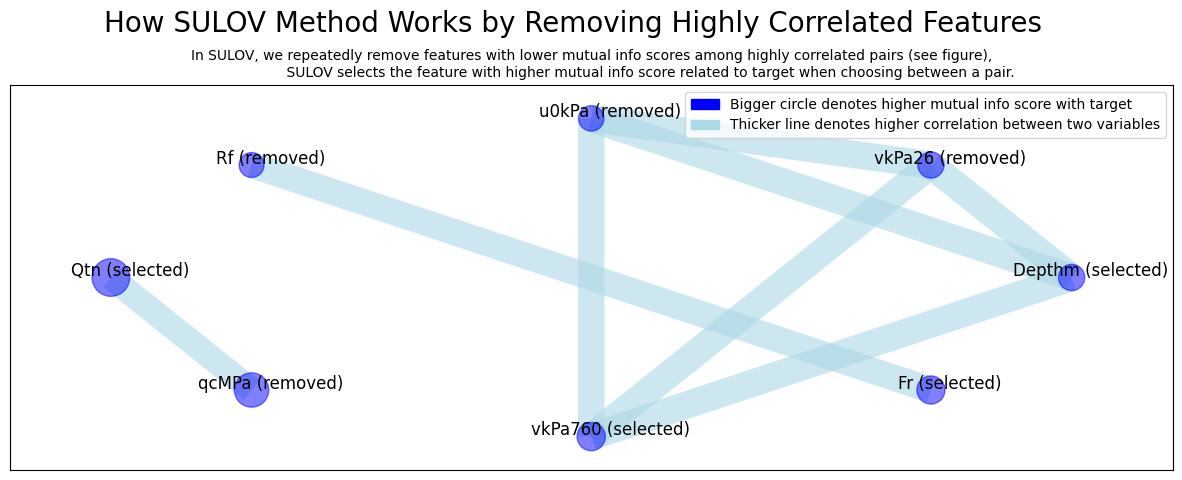

Time taken for SULOV method = 41 seconds
    Adding 0 categorical variables to reduced numeric variables  of 5
Final list of selected 5 vars after SULOV = ['fskPa', 'Qtn', 'vkPa760', 'Fr', 'Depthm']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 2 features per iteration...
    Number of booster rounds = 20
        Selected: ['Qtn', 'Depthm']
            Time taken for regular XGBoost feature selection = 4 seconds
        Selected: ['Qtn', 'Depthm']
            Time taken for regular XGBoost feature selection = 4 seconds
        Selected: ['Fr', 'Depthm']
            Time taken for regular XGBoost feature selection = 3 seconds
        Selected: ['Fr', 'Depthm']
         

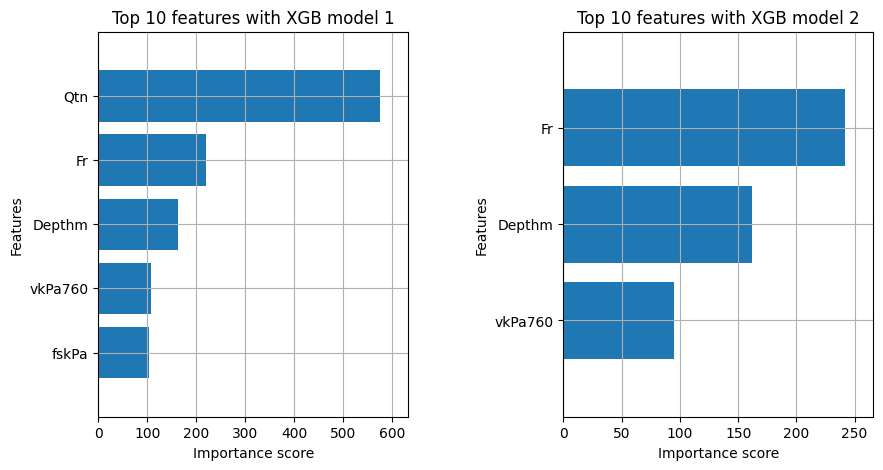

    Completed XGBoost feature selection in 8 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 3 important features:
['Qtn', 'Depthm', 'Fr']
Total Time taken for featurewiz selection = 49 seconds
Output contains a list of 3 important features and a train dataframe
Selected features (curated dataset): ['Qtn (-)', 'Depth (m)', 'Fr (%)']


In [5]:
# Use curated project dataset with featurewiz
# Assumes df, X, y, FEATURES, LABEL are defined in the previous curated loader cell

# Sanity check on variables
assert "df" in globals() and "X" in globals() and "y" in globals(), (
    "Run the curated loader cell above first."
)
assert len(FEATURES) > 0 and LABEL in df.columns, (
    "Curated FEATURES/LABEL are not set correctly."
)

# Run featurewiz on curated dataset
selected_fw, train_fw = featurewiz(
    dataname=df[FEATURES + [LABEL]].copy(),
    target=LABEL,
    corr_limit=0.7,
    verbose=2,
)
print("Selected features (curated dataset):", selected_fw)

In [ ]:
# Quick model comparison using RandomForest
from sklearn.ensemble import ExtraTreesClassifier

SEED = 42


# Helper for evaluation
def evaluate_with_features_df(df_in, feat_cols, target_col, name):
    X_local = df_in[feat_cols]
    y_local = df_in[target_col]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_local, y_local, test_size=0.25, random_state=SEED, stratify=y_local
    )
    clf_local = ExtraTreesClassifier(n_estimators=100, random_state=SEED)
    clf_local.fit(X_tr, y_tr)
    y_pred = clf_local.predict(X_te)
    print(f"=== {name} ===")
    print(classification_report(y_te, y_pred))
    return clf_local, X_te, y_te, y_pred


all_feats = FEATURES
clf_all, Xte_all, yte_all, yhat_all = evaluate_with_features_df(
    df, all_feats, LABEL, "All curated features"
)

clf_sel, Xte_sel, yte_sel, yhat_sel = evaluate_with_features_df(
    df, selected_fw, LABEL, "Selected by featurewiz (curated)"
)

=== All curated features ===
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76     15120
         1.0       0.79      0.77      0.78     22420
         2.0       0.77      0.77      0.77      8560
         3.0       0.83      0.72      0.77      1081
         4.0       0.83      0.79      0.81     23555
         5.0       0.84      0.87      0.86     50650
         6.0       0.84      0.84      0.84     42111
         7.0       0.90      0.90      0.90     38327

    accuracy                           0.84    201824
   macro avg       0.82      0.80      0.81    201824
weighted avg       0.84      0.84      0.84    201824



In [ ]:
# Optional: visualize importances for selected features
import pandas as pd
import plotly.express as px

if len(selected_fw) > 0:
    importances = pd.Series(
        clf_sel.feature_importances_, index=selected_fw
    ).sort_values(ascending=False)
    fig = px.bar(
        importances, title="RandomForest importances (selected curated features)"
    )
    fig.update_layout(xaxis_title="Feature", yaxis_title="Importance")
    fig.show()
else:
    print("featurewiz returned no features; skipping importance plot.")

## Takeaways
- `featurewiz` helps remove redundant and less-informative features automatically.
- Selected features often yield similar or better performance with simpler models.
- In geotechnics, feature selection aids interpretability and robustness when combining correlated CPT variables and derived indices.

Try modifying `corr_limit` or the base estimator (see `featurewiz` docs) and re-run to observe changes.